## Word2vec and Classification together

The consumer complains dataset can be found here: https://catalog.data.gov/dataset/consumer-complaint-database

If you want to experiment with another data set:
A very large set of Stack Overflow questions and tags is available at 
https://storage.googleapis.com/tensorflow-workshop-examples/stack-overflow-data.csv

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [60]:
df = pd.read_csv('Consumer_Complaints.csv')
df = df[['Consumer complaint narrative','Product']]
df = df[pd.notnull(df['Consumer complaint narrative'])]
df.rename(columns = {'Consumer complaint narrative':'narrative'}, inplace = True)
df.head(10)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (4,5,6,11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,narrative,Product
60,I am disputing this debt for XXXX XXXX that is...,Debt collection
91,Ok education credit management corporation XXX...,Debt collection
146,The Account from Ability Recovery Services has...,"Credit reporting, credit repair services, or o..."
171,I made cash & check deposit at my banks atm on...,Checking or savings account
172,Monterey Collection is trying to collect on a ...,Debt collection
173,I was looking through my credit karma and see ...,"Credit reporting, credit repair services, or o..."
174,"Hi, I am constantly being harassed by a compan...",Debt collection
187,I ATTENDED XXXX XXXX XXXX FOR A WHILE THEN COU...,Debt collection
189,First I received communications from Source RM...,Debt collection
208,On Friday XX/XX/18 I was called 6 times in a r...,Debt collection


In [39]:
df = df.sample(frac = 0.01)

In [40]:
df.shape

(3546, 2)

In [41]:
df.index = range(df.shape[0])

In [42]:
df['narrative'].apply(lambda x: len(x.split(' '))).sum()

698779

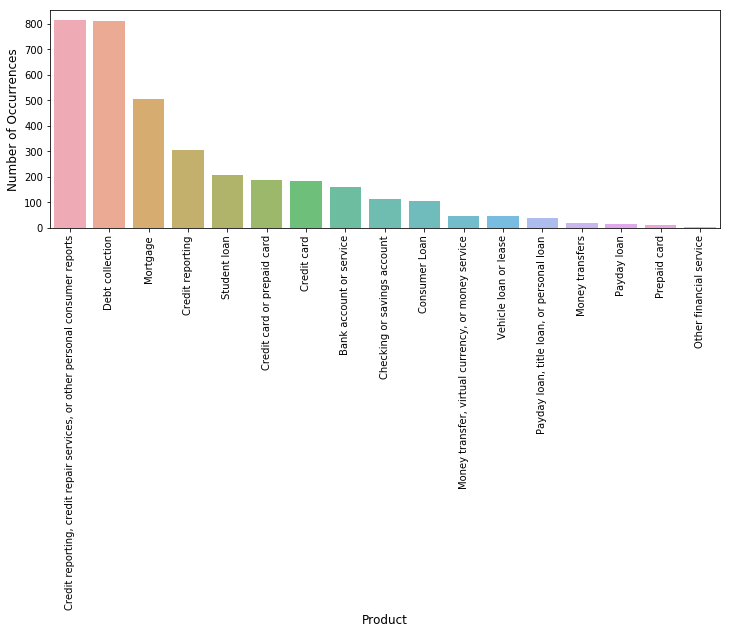

In [43]:
cnt_pro = df['Product'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=90)
plt.show();

The classes are imbalanced. However, a naive classifier that predicts everything to be Debt collection will only achieve over 20% accuracy.

Let's have a look a few examples of complaint narrative and its associated product.


In [44]:
def print_complaint(index):
    example = df[df.index == index][['narrative', 'Product']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])

In [45]:
print_complaint(0)

On XXXX XXXX, 2017, Equifax disclosed my personal information as part of a data breach. 

According to Equifax most of the consumer information breached includes names, Social Security numbers, birth dates, addresses, and in some instances, drivers license numbers. In addition, credit card numbers for approximately 209,000 consumers and certain dispute documents, which included personal identifying information, for approximately 182,000 consumers were accessed.
Product: Credit reporting, credit repair services, or other personal consumer reports


## Text preprocessing

In [46]:
#To do: Text preprocessing
#use BeautifulSoup and regular expressions to clean the text

In [47]:
df['narrative'] = df['narrative'].apply(cleanText)
df['narrative'][20]

'equifa incorrectly shows a    revolving credit card account as open. it is closed.'

## Train test split

In [48]:
train, test = train_test_split(df, test_size=0.3, random_state=42)


### Tokenization 

In [ ]:
import nltk
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [50]:
train_tagged = train.apply(
    lambda r: TaggedDocument(#use words from tokenized text (narrative) and tags from product ,  axis=1)
test_tagged = #to do: do the same for the test


This is what a training entry looks like - an example complaint narrative tagged by 'Credit reporting'.

In [62]:
train_tagged.values[30]

TaggedDocument(words=['phh', 'has', 'sent', 'us', 'fraudulent', 'statement', 'regarding', 'our', 'mortgage', 'they', 'have', 'refused', 'our', 'payments', 'after', 'they', 'received', 'our', 'last', 'trial', 'payment', 'of', 'our', 'loan', 'modification', '2016.', 'they', 'also', 'sent', 'us', 'an', 'intimidating', 'and', 'fraudulent', 'delinquency', 'notice', 'we', 'are', 'being', 'harassed', 'by', 'this', 'company.with', 'these', 'threatening', 'notices', 'being', 'sent', 'to', 'us'], tags=['Mortgage'])

## Training the model

We'll instantiate a Doc2Vec model-Distributed Bag of Words (DBOW). In the Word2Vec architecture, the two algorithm 
names are “continuous bag of words” (cbow) and “skip-gram” (sg); in the Doc2Vec architecture, the corresponding 
algorithms are “distributed bag of words” (dbow) and “distributed memory” (dm).

## DBOW

DBOW is the Doc2Vec model analogous to Skip-gram model in Word2Vec. 
The paragraph vectors are obtained by training a neural network on the task of predicting a 
probability distribution of words in a paragraph given a randomly-sampled word from the paragraph.

Training a Doc2Vec model is rather straight forward in Gensim, we initialize the model and train for 30 epochs:

We set the minimum word count to 2 in order to discard words with very few occurrences.


In [52]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [64]:
model_dbow = Doc2Vec(dm=0, vector_size=?, negative=?, hs=?, min_count=2, sample = ?, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 2482/2482 [00:00<00:00, 1089509.42it/s]


In [65]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 2482/2482 [00:00<00:00, 2377315.03it/s]


CPU times: user 22.1 s, sys: 594 ms, total: 22.7 s
Wall time: 8.06 s


# Building the final vector feature for the classifier

In [2]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [3]:
y_train, X_train = vec_for_learning(# put the model and the train)
y_test, X_test = vec_for_learning(# put the model and the train)

SyntaxError: unexpected EOF while parsing (<ipython-input-3-d0fc8ea16f00>, line 2)

In [57]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [58]:
from sklearn.metrics import accuracy_score, f1_score

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.22556390977443608
Testing F1 score: 0.2082000241331327


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
